In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from nltk.corpus import stopwords
from datetime import datetime, timedelta
import yfinance as yf
import re
from newsapi import NewsApiClient
import matplotlib.pyplot as plt
import spacy
from nltk.stem import PorterStemmer


class FinBERTSentimentAnalyzer:
    def __init__(self, api_key):
        self.newsapi = NewsApiClient(api_key=api_key)
        
        # FinBERT model
        self.model_name = "ProsusAI/finbert"
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(self.model_name)
        
        # FinBERT Labels
        self.labels = ['positive', 'negative', 'neutral']
        
    def preprocess_text(self, text):
        if not isinstance(text, str):
            return ""
        
        text = str(text).lower()
        text = re.sub(r'[^A-Za-z0-9 ]+', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        
        stop_words = set(stopwords.words('english'))
        text = ' '.join(word for word in text.split() if word not in stop_words)
        # FinBERT can handle lexical variations, so it can still provide good performance in sentiment analysis even without Lemmatization.
        return text
    
    
    def analyze_sentiment(self, text):
        try:
            text = self.preprocess_text(text)
            if not text:
                return 0.0
                
            # Encoding
            inputs = self.tokenizer(text, return_tensors="pt", truncation=True, 
                                  padding=True, max_length=128)
            
            # Get the output
            with torch.no_grad():
                outputs = self.model(**inputs)
                scores = torch.nn.functional.softmax(outputs.logits, dim=1)
                scores = scores[0].numpy()
            
            # Converting trichotomous results to scores between -1 and 1
            sentiment_score = scores[0] - scores[1]  
            
            # Normalized to 0-1 interval
            sentiment_score = (sentiment_score + 1) / 2
            
            return float(sentiment_score)
            
        except Exception as e:
            print(f"Error analyzing text: {text}")
            print(f"Error message: {str(e)}")
            return 0.0

    def analyze_stock_sentiment(self, phrase, ticker_symbol, days_back=30):
        """Analyzing Stock News Sentiment and Earnings Relationships"""
        # Get News data
        my_date = datetime.today() - timedelta(days=days_back)
        articles = self.newsapi.get_everything(
            q=phrase,
            from_param=my_date.strftime("%Y-%m-%d"),
            language="en",
            sort_by="relevancy",
            page_size=100
        )
        
        # Analyis the sentiment of each news headlines
        sentiment_data = []
        for article in articles['articles']:
            date = pd.to_datetime(article['publishedAt']).date()
            sentiment_score = self.analyze_sentiment(article['title'])
            sentiment_data.append({
                'Date': date,
                'Sentiment_Score': sentiment_score,
                'Title': article['title']
            })
        
        # Create data frame for notable events
        sentiment_df = pd.DataFrame(sentiment_data)
        
        # Calculate the distance between the sentiment score and 0.5 (0.5 is neutral)
        sentiment_df['sentiment_distance'] = abs(sentiment_df['Sentiment_Score'] - 0.5)
        
        # Sort the daily news by emotional extremes and select the most extreme headlines
        daily_sentiment = sentiment_df.sort_values('sentiment_distance', ascending=False) \
            .groupby('Date').agg({
                'Sentiment_Score': 'mean',  
                'Title': 'first',  
                'sentiment_distance': 'first'  
            }).reset_index()
        
        # Get stock data
        ticker = yf.Ticker(ticker_symbol)
        stock_data = ticker.history(start=my_date.strftime("%Y-%m-%d"))
        stock_data['Daily_Return'] = stock_data['Close'].pct_change()
        stock_data = stock_data.reset_index()[['Date', 'Daily_Return']]
        stock_data['Date'] = stock_data['Date'].dt.date
        
        # Merge daily sentiment scores and stock data
        merged_df = pd.merge(daily_sentiment, stock_data, on='Date', how='inner')
        
        return merged_df

def print_results(results_df):
    """Print analysis results and visualization"""
    # For most extreme 3 days
    most_positive = results_df.nlargest(3, 'Sentiment_Score')
    most_negative = results_df.nsmallest(3, 'Sentiment_Score')
    
    print("\n=== 📊 Notable Events ===\n")
    
    print("Most positive 3 days:")
    for _, row in most_positive.iterrows():
        print(f"📈 {row['Date']} | Sentiment score: {row['Sentiment_Score']:.3f} | Daily return: {row['Daily_Return']*100:.2f}%")
        print(f"   {row['Title']}\n")
    
    print("\nMost negative 3 days:")
    for _, row in most_negative.iterrows():
        print(f"📉 {row['Date']} | Sentiment score: {row['Sentiment_Score']:.3f} | Daily return: {row['Daily_Return']*100:.2f}%")
        print(f"   {row['Title']}\n")
    
    # Visualization
    plt.figure(figsize=(12, 6))
    
    plt.subplot(2, 1, 1)
    plt.plot(results_df['Date'], results_df['Sentiment_Score'], label='Sentiment Score', color='blue', marker='o')
    plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='netural line')
    plt.title('News Sentiment Scores and Stock Yield Changes')
    plt.xticks(rotation=45) 
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 1, 2)
    plt.bar(results_df['Date'], results_df['Daily_Return'] * 100, label='Daily Yield(%)', color='green', alpha=0.6)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


=== 📊 Notable Events ===

Most positive 3 days:
📈 2024-10-17 | Sentiment score: 0.718 | Daily return: 0.16%
   M4 MacBook Pro production appears well underway, as launch expected soon

📈 2024-10-10 | Sentiment score: 0.686 | Daily return: -0.22%
   Prime Day: Amazon is Not Done Yet, Here Are the 10 Best Deals for This Thursday

📈 2024-10-04 | Sentiment score: 0.633 | Daily return: 0.50%
   Amazon is clearing out stock with record-low prices on AirTags, matching last year’s Black Friday deal


Most negative 3 days:
📉 2024-10-23 | Sentiment score: 0.210 | Daily return: -2.16%
   Apple severely cuts Vision Pro production, and may stop it completely very soon

📉 2024-10-01 | Sentiment score: 0.267 | Daily return: -2.91%
   India factory fire may force Apple iPhone orders back to China

📉 2024-10-03 | Sentiment score: 0.272 | Daily return: -0.49%
   Amazon Unveils Major Price Cuts on The Latest MacBook Pro: Apple Hates Discounts but Can’t Do Anything About It



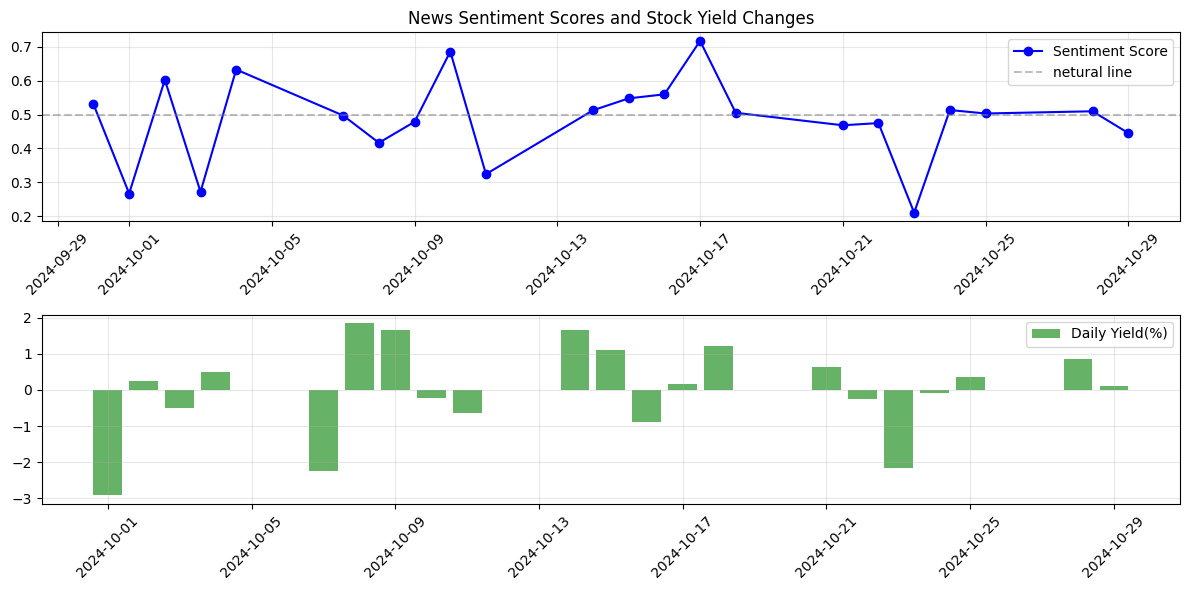

In [ ]:
analyzer = FinBERTSentimentAnalyzer(api_key='API_KEY')

results = analyzer.analyze_stock_sentiment(
    phrase='Apple stock',
    ticker_symbol='AAPL',
    days_back=30
)

print_results(results)